In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [30]:
import pulp
#solver_list = pulp.listSolvers(onlyAvailable=True)
#print(solver_list)
#['CPLEX_PY', 'PULP_CBC_CMD']

In [5]:
length_x = 1
length_y = 1

In [6]:
x_points = np.linspace(0,length_x,100)
y_points = np.linspace(0,length_y,100)

In [7]:
x_grid, y_grid = np.meshgrid(x_points,y_points)

In [8]:
def f_func(x,y,k1,k2,length_x,length_y):
    return np.cos(k1*np.pi*x/length_x)*np.cos(k2*np.pi*y/length_y)

In [9]:
max_wave = 5
wave_numbers = [(i,j) for i in range(max_wave) for j in range(max_wave)]
wave_numbers

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4)]

In [10]:
def inner_product(f1,f2):
    assert f1.shape==f2.shape
    return np.sum(f1*f2,axis=None)/(f1.size)

In [11]:
basis = {}
for k in wave_numbers:
    f_raw = f_func(x_grid,y_grid,k[0],k[1],length_x,length_y)
    h = np.sqrt(inner_product(f_raw,f_raw))
    basis[k] = f_raw/h

In [12]:
inner_product(basis[(0,1)],basis[(1,1)])

-6.217248937900877e-17

In [13]:
inner_product(basis[(1,1)],basis[(1,1)])

1.0

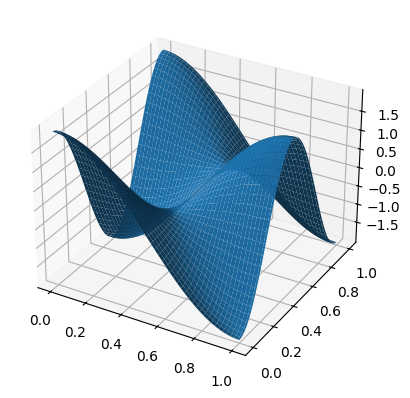

In [14]:
fig,ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_grid,y_grid,basis[(1,2)])

In [281]:
my_mean = np.array([0.5,0.5])
my_cov = np.array([[0.01,0],[0,0.16]])
my_inv_cov = np.linalg.inv(my_cov)
my_det_cov = np.linalg.det(my_cov)

In [282]:
my_pdf = np.zeros_like(x_grid)
for i in range(x_grid.shape[0]):
    for j in range(x_grid.shape[1]):
        xij = x_grid[i,j]
        yij = y_grid[i,j]
        vij = np.array([xij,yij])
        fij = np.exp(-0.5*np.transpose((vij-my_mean))@my_inv_cov@(vij-my_mean))/np.sqrt(4*np.pi*np.pi*my_det_cov)
        my_pdf[i,j] = fij

In [283]:
# optional overwrite with uniform
#my_pdf = np.ones_like(x_grid)/(length_x*length_y)

In [284]:
# uniform in a subset
#my_pdf = (x_grid**2 + y_grid**2 >= 0.6)

In [285]:
my_pdf = my_pdf/inner_product(my_pdf,basis[(0,0)])

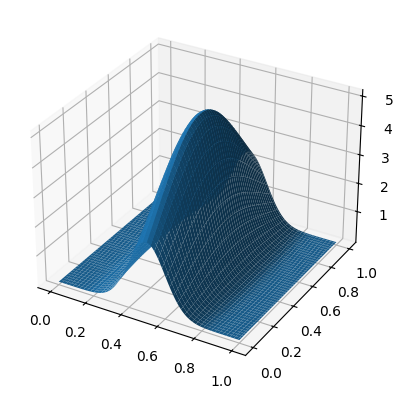

In [286]:
fig,ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_grid,y_grid,my_pdf)

In [287]:
eta = {}
for k in wave_numbers:
    eta[k] = inner_product(my_pdf,basis[k])

In [288]:
fourier_pdf = np.zeros_like(x_grid)
for k in wave_numbers:
    fourier_pdf += eta[k]*basis[k]

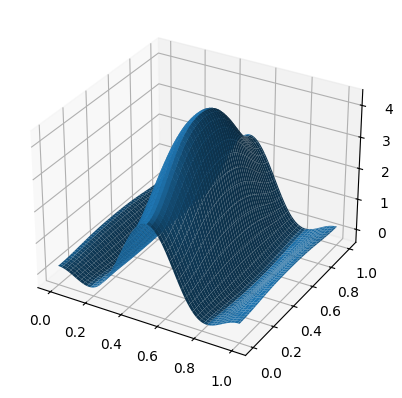

In [289]:
fig,ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_grid,y_grid,fourier_pdf)

In [290]:
wp_num_x = 8
wp_num_y = 8
x_wp,y_wp = np.meshgrid(np.linspace(0,length_x,wp_num_x),np.linspace(0,length_x,wp_num_y))

In [291]:
num_wp = wp_num_x*wp_num_y

In [292]:
wp_array = np.vstack((np.reshape(x_wp,(1,x_wp.size)),np.reshape(y_wp,(1,y_wp.size))))

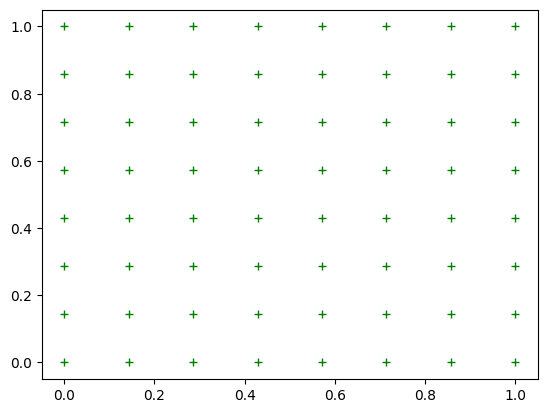

In [293]:
plt.plot(x_wp,y_wp,'g+')

In [294]:
links = [(i,j) for i in range(x_wp.size) for j in range(x_wp.size) if i!=j and np.linalg.norm(wp_array[:,i] - wp_array[:,j])<=1.1*length_x/(wp_num_x-1)]

In [295]:
# add a magic node for start and finish
links += [(-1,i) for i in range(num_wp)]
links += [(i,-1) for i in range(num_wp)]

In [296]:
wp_list = [-1] + [i for i in range(num_wp)]

In [297]:
prob = pulp.LpProblem('ergo')

In [298]:
x = pulp.LpVariable.dicts("x",links,0,1,pulp.LpInteger)

In [299]:
# continuity - must leave everywhere we go
for w in wp_list:
    prob.addConstraint(sum([x[i,j] for (i,j) in links if i==w]) == sum(sum([x[i,j] for (i,j) in links if j==w])))

In [300]:
# can't go anywhere twice - would be nice to omit this, but then how to include subtours?
for w in wp_list:
    prob.addConstraint(sum([x[i,j] for (i,j) in links if i==w]) <= 1)

In [301]:
v = pulp.LpVariable.dicts("v",[-1]+[i for i in range(num_wp)],0,num_wp,pulp.LpContinuous)

In [302]:
# subtour elimination by MTZ
for (i,j) in links:
    if j!=-1:
        prob.addConstraint(v[j]>=v[i]+1-num_wp*(1-x[i,j]))

In [303]:
num_moves = 16
prob.addConstraint(sum([x[lk] for lk in links])==num_moves)

In [304]:
f_traj = {}
for (i,j) in links:
    if i!=-1 and j!=-1:
        sample_point = 0.5*(wp_array[:,j] + wp_array[:,i])
        for k in wave_numbers:
            f_traj[(i,j,k)] = f_func(sample_point[0],sample_point[1],k[0],k[1],length_x,length_y)

In [305]:
s = pulp.LpVariable.dicts("s",wave_numbers,0,1,pulp.LpContinuous)

In [306]:
lam = {}
for k in wave_numbers:
    lam[k] = 1/(1+k[0]*k[0] + k[1]*k[1])**(3/2)

In [307]:
for k in wave_numbers:
    prob.addConstraint(s[k] >= (eta[k] - sum([f_traj[i,j,k]*x[i,j] for (i,j) in links if i!=-1 and j!=-1])/num_moves))
    prob.addConstraint(s[k] >= -(eta[k] - sum([f_traj[i,j,k]*x[i,j] for (i,j) in links if i!=-1 and j!=-1])/num_moves))

In [308]:
prob.setObjective(sum([lam[k]*s[k] for k in wave_numbers]))

In [309]:
#prob.solve()
prob.solve(solver=pulp.CPLEX_PY())
print(pulp.LpStatus[prob.status])

Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve eliminated 0 rows and 1 columns.
MIP Presolve modified 896 coefficients.
Reduced MIP has 469 rows, 441 columns, and 12754 nonzeros.
Reduced MIP has 352 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (6.34 ticks)
Probing time = 0.00 sec. (0.63 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 469 rows, 441 columns, and 12754 nonzeros.
Reduced MIP has 352 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (5.57 ticks)
Probing time = 0.00 sec. (0.67 ticks)
Clique table members: 177.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 0.01 sec. (11.95 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Inte

In [310]:
moves = [(i,j) for (i,j) in links if x[i,j].value()>=0.5]
moves

[(12, 20),
 (13, 12),
 (18, 26),
 (19, 18),
 (20, 19),
 (26, 27),
 (27, 35),
 (35, 43),
 (36, 37),
 (37, 29),
 (43, 51),
 (44, 36),
 (51, 52),
 (52, 44),
 (-1, 13),
 (29, -1)]

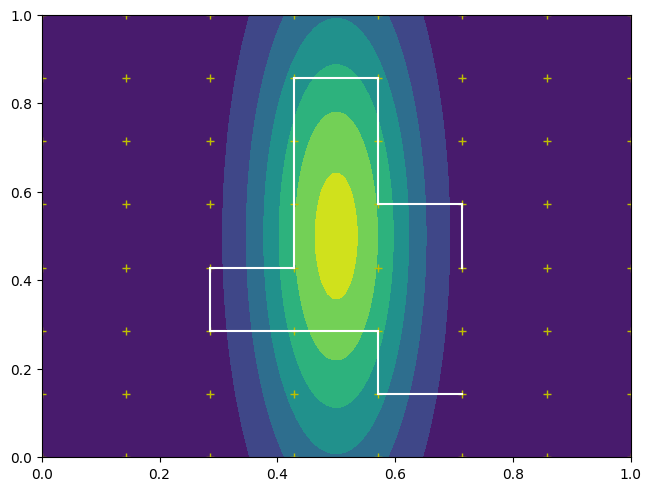

In [311]:
fig,ax = plt.subplots(layout='constrained')
ax.contourf(x_grid,y_grid,my_pdf)
ax.plot(x_wp,y_wp,'y+')
for (i,j) in moves:
    if i!=-1 and j!=-1:
        plt.plot(wp_array[0,[i,j]],wp_array[1,[i,j]],'w-')